In [1]:
# pip install psutil==5.8.0
# pip install numpy==1.23.1

from typing import Dict, Tuple, List

import torch
import torch.nn as nn
import numpy as np
from random import randint
from scipy.io import loadmat
import matplotlib
import sys

sys.path.append('/garmentor')

from configs import paths

# Data structures and functions for rendering
from pytorch3d.structures import Meshes
from pytorch3d.renderer import (
    PerspectiveCameras,
    OrthographicCameras,
    PointLights,
    RasterizationSettings,
    MeshRasterizer,
    HardPhongShader,
    TexturesUV,
    TexturesVertex,
    BlendParams,
    Textures)

import utils.sampling_utils

from configs.poseMF_shapeGaussian_net_config import get_cfg_defaults
from models.parametric_model import ParametricModel
from configs.poseMF_shapeGaussian_net_config import get_cfg_defaults
from utils.augmentation.cam_augmentation import augment_cam_t_numpy
from utils.garment_classes import GarmentClasses
from vis.colors import NoColors, GarmentColors, BodyColors
from utils.mesh_utils import concatenate_meshes
from vis.visualizers.clothed import ClothedVisualizer

from tailornet_for_garmentor.models.smpl4garment_utils import SMPL4GarmentOutput

In [2]:
cfg = get_cfg_defaults()

delta_betas_std_vector = np.ones(
    cfg.MODEL.NUM_SMPL_BETAS, 
    dtype=np.float32) * \
        cfg.TRAIN.SYNTH_DATA.AUGMENT.SMPL.SHAPE_STD
mean_shape = np.zeros(
    cfg.MODEL.NUM_SMPL_BETAS, 
    dtype=np.float32)
shape_min = cfg.TRAIN.SYNTH_DATA.AUGMENT.SMPL.SHAPE_MIN
shape_max = cfg.TRAIN.SYNTH_DATA.AUGMENT.SMPL.SHAPE_MAX
delta_style_std_vector = np.ones(
    cfg.MODEL.NUM_STYLE_PARAMS, 
    dtype=np.float32) * \
        cfg.TRAIN.SYNTH_DATA.AUGMENT.GARMENTOR.STYLE_STD
mean_style = np.zeros(
    cfg.MODEL.NUM_STYLE_PARAMS, 
    dtype=np.float32)
style_min = cfg.TRAIN.SYNTH_DATA.AUGMENT.GARMENTOR.STYLE_MIN
style_max = cfg.TRAIN.SYNTH_DATA.AUGMENT.GARMENTOR.STYLE_MAX
mean_cam_t = np.array(
    cfg.TRAIN.SYNTH_DATA.MEAN_CAM_T, 
    dtype=np.float32)

device = 'cuda:0'

In [3]:
sampling_cfg = cfg.TRAIN.SYNTH_DATA.SAMPLING
pose_sampler = getattr(utils.sampling_utils, f'sample_{sampling_cfg.POSE}_pose')
global_orient_sampler = getattr(utils.sampling_utils, f'sample_{sampling_cfg.GLOBAL_ORIENT}_global_orient')
shape_sampler = getattr(utils.sampling_utils, f'sample_{sampling_cfg.SHAPE}_shape')
style_sampler = getattr(utils.sampling_utils, f'sample_{sampling_cfg.STYLE}_style')

In [4]:
gender = 'male'
upper_class = 't-shirt'
lower_class = 'pant'

clothed_visualizer = ClothedVisualizer(
    device=device,
    gender=gender,
    upper_class=upper_class,
    lower_class=lower_class,
    backgrounds_dir_path=None,
    img_wh=512
)

Initializing (male, t-shirt, pant) model...
USING LF LOG DIR:  /data/tailornet/weights/t-shirt_male_weights/tn_orig_lf/t-shirt_male
USING HF LOG DIR:  /data/tailornet/weights/t-shirt_male_weights/tn_orig_hf/t-shirt_male
USING SS2G LOG DIR:  /data/tailornet/weights/t-shirt_male_weights/tn_orig_ss2g/t-shirt_male
loading /data/tailornet/weights/t-shirt_male_weights/tn_orig_hf/t-shirt_male/008_000/lin.pth.tar
loading /data/tailornet/weights/t-shirt_male_weights/tn_orig_hf/t-shirt_male/006_023/lin.pth.tar
loading /data/tailornet/weights/t-shirt_male_weights/tn_orig_hf/t-shirt_male/008_002/lin.pth.tar
loading /data/tailornet/weights/t-shirt_male_weights/tn_orig_hf/t-shirt_male/006_016/lin.pth.tar
loading /data/tailornet/weights/t-shirt_male_weights/tn_orig_hf/t-shirt_male/007_018/lin.pth.tar
loading /data/tailornet/weights/t-shirt_male_weights/tn_orig_hf/t-shirt_male/008_009/lin.pth.tar
loading /data/tailornet/weights/t-shirt_male_weights/tn_orig_hf/t-shirt_male/008_007/lin.pth.tar
loading /

In [5]:
data = np.load(paths.TRAIN_POSES_PATH)
fnames = data['fnames']
poses = data['poses']
indices = [i for i, x in enumerate(fnames)
            if (x.startswith('h36m') or x.startswith('up3d') or x.startswith('3dpw'))]
all_poses = np.stack([poses[i] for i in indices], axis=0)

## Frontal global orient sampling

In [26]:
#pose = pose_sampler(
#    all_poses=None
#)
whole_pose = np.zeros(72)
#orient = global_orient_sampler(
#    all_poses=None
#)
#whole_pose = np.concatenate([pose, orient], axis=0)

shape = shape_sampler(
    mean_params=mean_shape,
    std_vector=delta_betas_std_vector,
    min_value=shape_min,
    max_value=shape_max
)
style_vector = style_sampler(
    num_garment_classes=4,
    mean_params=mean_style,
    std_vector=delta_style_std_vector,
    min_value=style_min,
    max_value=style_max
)

frontal_orients_list = [
    [.5, 0., 0.],
    [-0.4, 0., 0.],
    [0., 0.6, 0.],
    [0., -0.6, 0.],
    [0., 0., 0.5],  # this will be zero in the actual sampling strategy
    [0., 0., -0.5]  # this will be zero in the actual sampling strategy
]

rgb_imgs = []
for frontal_orient in frontal_orients_list:
    whole_pose[0] = frontal_orient[0]
    whole_pose[1] = frontal_orient[1]
    whole_pose[2] = frontal_orient[2]

    rgb_img, _, _ = clothed_visualizer.vis_from_params(
        pose=whole_pose,
        shape=shape,
        style_vector=style_vector
    )
    rgb_imgs.append(rgb_img.detach().cpu().numpy())

Running TailorNet (upper -> t-shirt(label=0))...
Running SMPL4Garment (t-shirt)...
Running TailorNet (lower -> pant(label=3))...
Running SMPL4Garment (pant)...
Rendering body mesh...
Rendering upper mesh...
Rendering lower mesh...
Running TailorNet (upper -> t-shirt(label=0))...
Running SMPL4Garment (t-shirt)...
Running TailorNet (lower -> pant(label=3))...
Running SMPL4Garment (pant)...
Rendering body mesh...
Rendering upper mesh...
Rendering lower mesh...
Running TailorNet (upper -> t-shirt(label=0))...
Running SMPL4Garment (t-shirt)...
Running TailorNet (lower -> pant(label=3))...
Running SMPL4Garment (pant)...
Rendering body mesh...
Rendering upper mesh...
Rendering lower mesh...
Running TailorNet (upper -> t-shirt(label=0))...
Running SMPL4Garment (t-shirt)...
Running TailorNet (lower -> pant(label=3))...
Running SMPL4Garment (pant)...
Rendering body mesh...
Rendering upper mesh...
Rendering lower mesh...
Running TailorNet (upper -> t-shirt(label=0))...
Running SMPL4Garment (t-shi

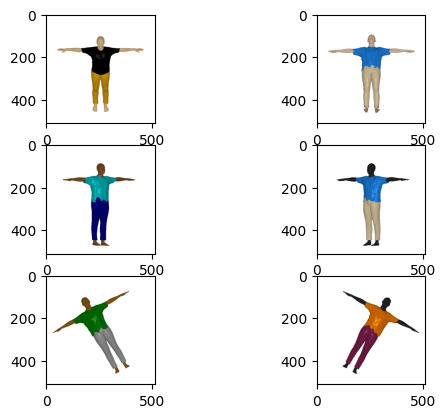

<Figure size 1000x1000 with 0 Axes>

In [27]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(3, 2)

plt.figure(figsize=(10, 10))
#plt.imshow(img[..., :3])
#plt.axis("off");
axs[0,0].imshow(rgb_imgs[0])
axs[0,1].imshow(rgb_imgs[1])
axs[1,0].imshow(rgb_imgs[2])
axs[1,1].imshow(rgb_imgs[3])
axs[2,0].imshow(rgb_imgs[4])
axs[2,1].imshow(rgb_imgs[5])

## Diverse global orient sampling

In [42]:
#pose = pose_sampler(
#    all_poses=None
#)
whole_pose = np.zeros(72)
#orient = global_orient_sampler(
#    all_poses=None
#)
#whole_pose = np.concatenate([pose, orient], axis=0)

shape = shape_sampler(
    mean_params=mean_shape,
    std_vector=delta_betas_std_vector,
    min_value=shape_min,
    max_value=shape_max
)
style_vector = style_sampler(
    num_garment_classes=4,
    mean_params=mean_style,
    std_vector=delta_style_std_vector,
    min_value=style_min,
    max_value=style_max
)

frontal_orients_list = [
    [.5, 0., 0.],
    [-0.4, 0., 0.],
    [0., 1.5, 0.],      # it will be unconstrained in the actual sampling strategy, i.e., [-3, 3]
    [0., -1.5, 0.],     # it will be unconstrained in the actual sampling strategy, i.e., [-3, 3]
    [0., 0., 0.1],
    [0., 0., -0.1]
]

rgb_imgs = []
for frontal_orient in frontal_orients_list:
    whole_pose[0] = frontal_orient[0]
    whole_pose[1] = frontal_orient[1]
    whole_pose[2] = frontal_orient[2]

    rgb_img, _, _ = clothed_visualizer.vis_from_params(
        pose=whole_pose,
        shape=shape,
        style_vector=style_vector
    )
    rgb_imgs.append(rgb_img.detach().cpu().numpy())

Running TailorNet (upper -> t-shirt(label=0))...
Running SMPL4Garment (t-shirt)...
Running TailorNet (lower -> pant(label=3))...
Running SMPL4Garment (pant)...
Rendering body mesh...
Rendering upper mesh...
Rendering lower mesh...
Running TailorNet (upper -> t-shirt(label=0))...
Running SMPL4Garment (t-shirt)...
Running TailorNet (lower -> pant(label=3))...
Running SMPL4Garment (pant)...
Rendering body mesh...
Rendering upper mesh...
Rendering lower mesh...
Running TailorNet (upper -> t-shirt(label=0))...
Running SMPL4Garment (t-shirt)...
Running TailorNet (lower -> pant(label=3))...
Running SMPL4Garment (pant)...
Rendering body mesh...
Bin size was too small in the coarse rasterization phase. This caused an overflow, meaning output may be incomplete. To solve, try increasing max_faces_per_bin / max_points_per_bin, decreasing bin_size, or setting bin_size to 0 to use the naive rasterization.Bin size was too small in the coarse rasterization phase. This caused an overflow, meaning outpu

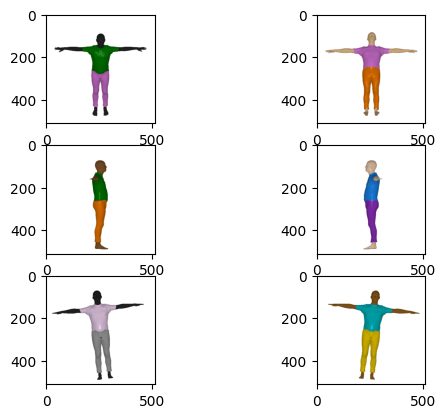

<Figure size 1000x1000 with 0 Axes>

In [43]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(3, 2)

plt.figure(figsize=(10, 10))
#plt.imshow(img[..., :3])
#plt.axis("off");
axs[0,0].imshow(rgb_imgs[0])
axs[0,1].imshow(rgb_imgs[1])
axs[1,0].imshow(rgb_imgs[2])
axs[1,1].imshow(rgb_imgs[3])
axs[2,0].imshow(rgb_imgs[4])
axs[2,1].imshow(rgb_imgs[5])